# RLearN Model Evaluation

This notebook provides comprehensive evaluation of the RLearN (Video-Language Conditioned Reward Model) using:

1. **VOC-S (Value-Order Correlation for Success)**: Measures whether per-frame rewards increase as successful execution unfolds
2. **Success vs Failure Detection**: Tests the model's ability to distinguish correct vs incorrect language conditions
3. **Live Reward Visualization**: Shows predicted rewards alongside video frames

## Requirements

```bash
pip install matplotlib seaborn plotly ipywidgets
```


In [1]:
cd /Users/pepijnkooijmans/Documents/GitHub/lerobot

/Users/pepijnkooijmans/Documents/GitHub/lerobot


/Users/pepijnkooijmans/miniconda3/envs/lerobot/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import sys
from pathlib import Path

# Add src to path for imports
sys.path.append(str(Path.cwd().parent / "src"))

import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch

warnings.filterwarnings("ignore")


# LeRobot imports
from lerobot.constants import OBS_IMAGES, OBS_LANGUAGE
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.policies.rlearn.evaluation import (
    RLearnEvaluator,
)
from lerobot.policies.rlearn.modeling_rlearn import RLearNPolicy

print("✓ Imports successful")

✓ Imports successful


## 1. Setup Model and Dataset

Load your trained RLearN model and the dataset for evaluation.


In [3]:
# Configuration
DATASET_REPO = "pepijn223/rewards_bc_z3"  # Change to your dataset
MODEL_PATH = "pepijn223/rlearn_rewards_bcz_5000"  # Change to your model checkpoint
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
NUM_EVAL_EPISODES = 10  # Number of episodes for evaluation

print(f"Using device: {DEVICE}")

# Load dataset
print("Loading dataset...")
dataset = LeRobotDataset(
    repo_id=DATASET_REPO,
    episodes=list(range(10)),  # Load first 10 episodes for evaluation
    download_videos=True,
)

print(f"Dataset loaded: {dataset.num_episodes} episodes, {dataset.num_frames} frames")
print(f"Features: {list(dataset.features.keys())}")
print(f"FPS: {dataset.fps}")

Using device: mps
Loading dataset...
Dataset loaded: 10 episodes, 1175 frames
Features: ['observation.images.image', 'observation.state', 'action', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'next.reward']
FPS: 10


In [4]:
# Load or create model
print("Setting up model...")

print(f"Loading trained model from Hugging Face Hub: {MODEL_PATH}")
model = RLearNPolicy.from_pretrained(MODEL_PATH)

model = model.to(DEVICE)
model.eval()

print(f"✓ Model ready on {DEVICE}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Setting up model...
Loading trained model from Hugging Face Hub: pepijn223/rlearn_rewards_bcz_5000


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

✓ Model ready on mps
  Parameters: 139,442,560
  Trainable: 19,502,080


## 2. VOC-S Evaluation

Evaluate Value-Order Correlation for Success - measures whether predicted rewards correlate with temporal progress.


In [5]:
# Create evaluator
evaluator = RLearnEvaluator(model, device=DEVICE)

# Run VOC-S evaluation
print("Running VOC-S evaluation...")
voc_results = evaluator.evaluate_voc_s(
    dataset=dataset, num_episodes=NUM_EVAL_EPISODES, use_interquartile_mean=True
)

print("\n" + "=" * 50)
print("VOC-S RESULTS")
print("=" * 50)
print(f"Mean Correlation: {voc_results['voc_s_mean']:.4f}")
print(f"Std Correlation:  {voc_results['voc_s_std']:.4f}")
print(f"IQM Correlation:  {voc_results['voc_s_iqm']:.4f}")
print(f"Episodes:         {voc_results['num_episodes']}")
print("=" * 50)

Running VOC-S evaluation...
Evaluating VOC-S on 10 episodes...


Computing VOC-S:   0%|          | 0/10 [00:00<?, ?it/s]objc[83562]: Class AVFFrameReceiver is implemented in both /Users/pepijnkooijmans/miniconda3/envs/lerobot/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x15fac03a8) and /Users/pepijnkooijmans/miniconda3/envs/lerobot/lib/libavdevice.61.3.100.dylib (0x3088bc848). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[83562]: Class AVFAudioReceiver is implemented in both /Users/pepijnkooijmans/miniconda3/envs/lerobot/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x15fac03f8) and /Users/pepijnkooijmans/miniconda3/envs/lerobot/lib/libavdevice.61.3.100.dylib (0x3088bc898). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
Computing VOC-S:   0%|          | 0/10 [00:26<?, ?it/s]


KeyboardInterrupt: 

## 3. Detailed reward visualization

Visualizing first 2 episodes...


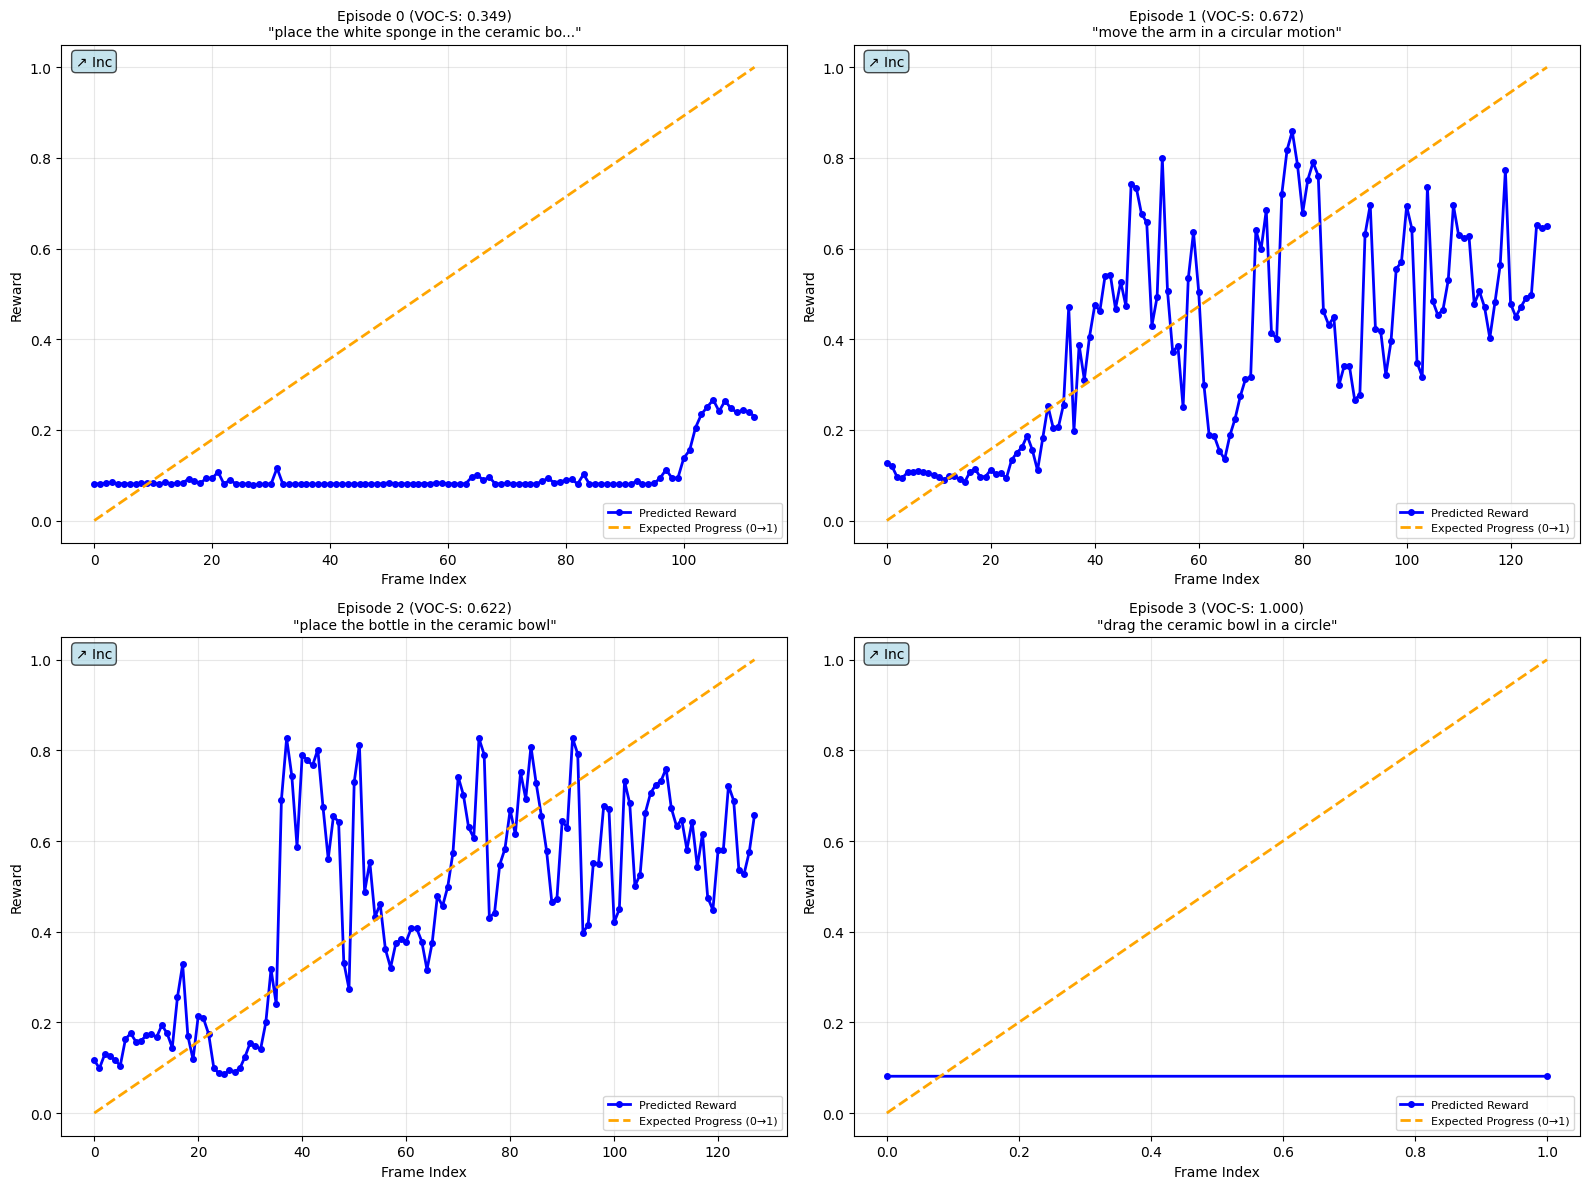


Detailed Episode Statistics:
Episode 0:
  Language: place the white sponge in the ceramic bowl
  Frames: 113
  VOC-S (Spearman ρ): 0.3486 (p=0.0002)
  Reward range: [0.078, 0.266]
  Trend: ↗ Increasing
--------------------------------------------------------------------------------
Episode 1:
  Language: move the arm in a circular motion
  Frames: 128
  VOC-S (Spearman ρ): 0.6721 (p=0.0000)
  Reward range: [0.085, 0.858]
  Trend: ↗ Increasing
--------------------------------------------------------------------------------
Episode 2:
  Language: place the bottle in the ceramic bowl
  Frames: 128
  VOC-S (Spearman ρ): 0.6220 (p=0.0000)
  Reward range: [0.085, 0.827]
  Trend: ↗ Increasing
--------------------------------------------------------------------------------
Episode 3:
  Language: drag the ceramic bowl in a circle
  Frames: 2
  VOC-S (Spearman ρ): 1.0000 (p=nan)
  Reward range: [0.081, 0.081]
  Trend: ↗ Increasing
----------------------------------------------------------------

In [8]:
# Static visualization function that works well in VS Code
def get_episode_data(episode_idx, max_frames=32):
    """Extract frames, language, and predict rewards for an episode."""
    try:
        # Get episode data
        ep_start = dataset.episode_data_index["from"][episode_idx].item()
        ep_end = dataset.episode_data_index["to"][episode_idx].item()
        episode_length = min(ep_end - ep_start, max_frames)

        # Collect frames and get language
        frames = []
        language = None

        for frame_idx in range(episode_length):
            global_idx = ep_start + frame_idx
            frame_data = dataset[global_idx]

            # Extract image
            if OBS_IMAGES in frame_data:
                img = frame_data[OBS_IMAGES]
            else:
                img_keys = [k for k in frame_data.keys() if "image" in k.lower()]
                if img_keys:
                    img = frame_data[img_keys[0]]
                else:
                    continue

            if isinstance(img, np.ndarray):
                img = torch.from_numpy(img)

            # Ensure CHW format
            if len(img.shape) == 3 and img.shape[-1] in [1, 3, 4]:
                img = img.permute(2, 0, 1)

            # Resize to expected input size (256x256 for SigLIP2) BEFORE stacking
            if img.shape[-2:] != (256, 256):
                import torch.nn.functional as F

                img = F.interpolate(
                    img.unsqueeze(0), size=(256, 256), mode="bilinear", align_corners=False
                ).squeeze(0)

            # Normalize to [0, 1] if needed
            if img.dtype == torch.uint8:
                img = img.float() / 255.0

            frames.append(img)

            # Get language
            if language is None:
                if OBS_LANGUAGE in frame_data:
                    language = frame_data[OBS_LANGUAGE]
                    if isinstance(language, list):
                        language = language[0]
                elif "task" in frame_data:
                    language = frame_data["task"]
                else:
                    language = "No language provided"

        if not frames:
            return None, None, None, None

        frames_tensor = torch.stack(frames)

        # Predict rewards
        rewards = evaluator.predict_episode_rewards(frames_tensor, language)

        return frames_tensor, language, rewards, episode_length

    except Exception as e:
        print(f"Error processing episode {episode_idx}: {e}")
        return None, None, None, None


def visualize_multiple_episodes(episode_indices=[0, 1, 2, 3], max_frames=32):
    """Visualize multiple episodes in a grid layout."""
    n_episodes = len(episode_indices)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    from scipy.stats import spearmanr

    for i, episode_idx in enumerate(episode_indices[:4]):  # Limit to 4 episodes
        if i >= len(axes):
            break

        frames, language, rewards, episode_length = get_episode_data(episode_idx, max_frames)

        if rewards is None:
            axes[i].text(
                0.5,
                0.5,
                f"Episode {episode_idx}\nNo data available",
                ha="center",
                va="center",
                transform=axes[i].transAxes,
            )
            axes[i].set_title(f"Episode {episode_idx} - Error")
            continue

        # Plot rewards
        time_steps = range(len(rewards))
        axes[i].plot(
            time_steps, rewards, "b-", linewidth=2, marker="o", markersize=4, label="Predicted Reward"
        )

        # Add expected progress line
        expected_progress = np.linspace(0, 1, len(rewards))
        axes[i].plot(
            time_steps,
            expected_progress,
            "orange",
            linestyle="--",
            linewidth=2,
            label="Expected Progress (0→1)",
        )

        # Compute VOC-S
        frame_indices = np.arange(1, len(rewards) + 1)
        correlation, p_value = spearmanr(frame_indices, rewards)

        # Format title with key info
        title = f'Episode {episode_idx} (VOC-S: {correlation:.3f})\n"{language[:40]}{"..." if len(language) > 40 else ""}"'
        axes[i].set_title(title, fontsize=10)
        axes[i].set_xlabel("Frame Index")
        axes[i].set_ylabel("Reward")
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

        # Add trend indicator
        trend = "↗ Inc" if correlation > 0.1 else "↘ Dec" if correlation < -0.1 else "→ Flat"
        axes[i].text(
            0.02,
            0.98,
            trend,
            transform=axes[i].transAxes,
            verticalalignment="top",
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
        )

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDetailed Episode Statistics:")
    print("=" * 80)

    for episode_idx in episode_indices:
        frames, language, rewards, episode_length = get_episode_data(episode_idx, max_frames)

        if rewards is None:
            print(f"Episode {episode_idx}: No data available")
            continue

        frame_indices = np.arange(1, len(rewards) + 1)
        correlation, p_value = spearmanr(frame_indices, rewards)

        print(f"Episode {episode_idx}:")
        print(f"  Language: {language}")
        print(f"  Frames: {len(rewards)}")
        print(f"  VOC-S (Spearman ρ): {correlation:.4f} (p={p_value:.4f})")
        print(f"  Reward range: [{rewards.min():.3f}, {rewards.max():.3f}]")
        print(
            f"  Trend: {'↗ Increasing' if correlation > 0.1 else '↘ Decreasing' if correlation < -0.1 else '→ Flat'}"
        )
        print("-" * 80)


def show_episode_frames(episode_idx, max_frames=32, show_frames=[0, -1]):
    """Show specific frames from an episode alongside reward curve."""
    frames, language, rewards, episode_length = get_episode_data(episode_idx, max_frames)

    if rewards is None:
        print(f"No data available for episode {episode_idx}")
        return

    # Create figure
    fig = plt.figure(figsize=(15, 8))

    # Reward curve (top half)
    ax1 = plt.subplot(2, len(show_frames) + 1, (1, len(show_frames) + 1))
    time_steps = range(len(rewards))
    ax1.plot(time_steps, rewards, "b-", linewidth=2, marker="o", markersize=4, label="Predicted Reward")
    expected_progress = np.linspace(0, 1, len(rewards))
    ax1.plot(time_steps, expected_progress, "orange", linestyle="--", linewidth=2, label="Expected (0→1)")

    # Highlight selected frames
    for frame_idx in show_frames:
        actual_idx = frame_idx if frame_idx >= 0 else len(rewards) + frame_idx
        if 0 <= actual_idx < len(rewards):
            ax1.axvline(x=actual_idx, color="red", linestyle=":", alpha=0.7)
            ax1.plot(actual_idx, rewards[actual_idx], "ro", markersize=8)

    from scipy.stats import spearmanr

    frame_indices = np.arange(1, len(rewards) + 1)
    correlation, _ = spearmanr(frame_indices, rewards)

    ax1.set_title(f'Episode {episode_idx} - VOC-S: {correlation:.3f}\n"{language}"', fontsize=12)
    ax1.set_xlabel("Frame Index")
    ax1.set_ylabel("Predicted Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Show selected frames (bottom half)
    for i, frame_idx in enumerate(show_frames):
        actual_idx = frame_idx if frame_idx >= 0 else len(frames) + frame_idx

        if 0 <= actual_idx < len(frames):
            ax = plt.subplot(2, len(show_frames) + 1, len(show_frames) + 2 + i)

            # Convert frame for display
            frame = frames[actual_idx].permute(1, 2, 0).cpu().numpy()
            if frame.max() > 1.0:
                frame = frame / 255.0
            frame = np.clip(frame, 0, 1)

            ax.imshow(frame)
            ax.set_title(f"Frame {actual_idx}\nReward: {rewards[actual_idx]:.3f}", fontsize=10)
            ax.axis("off")

    plt.tight_layout()
    plt.show()


# Visualize multiple episodes at once
print("Visualizing first 4 episodes...")
visualize_multiple_episodes([0, 1, 2, 3], max_frames=128)

## 4. Success vs Failure Detection Visualization

Test the model's ability to distinguish correct vs incorrect language conditions.



DETECTION TEST - EPISODE 0


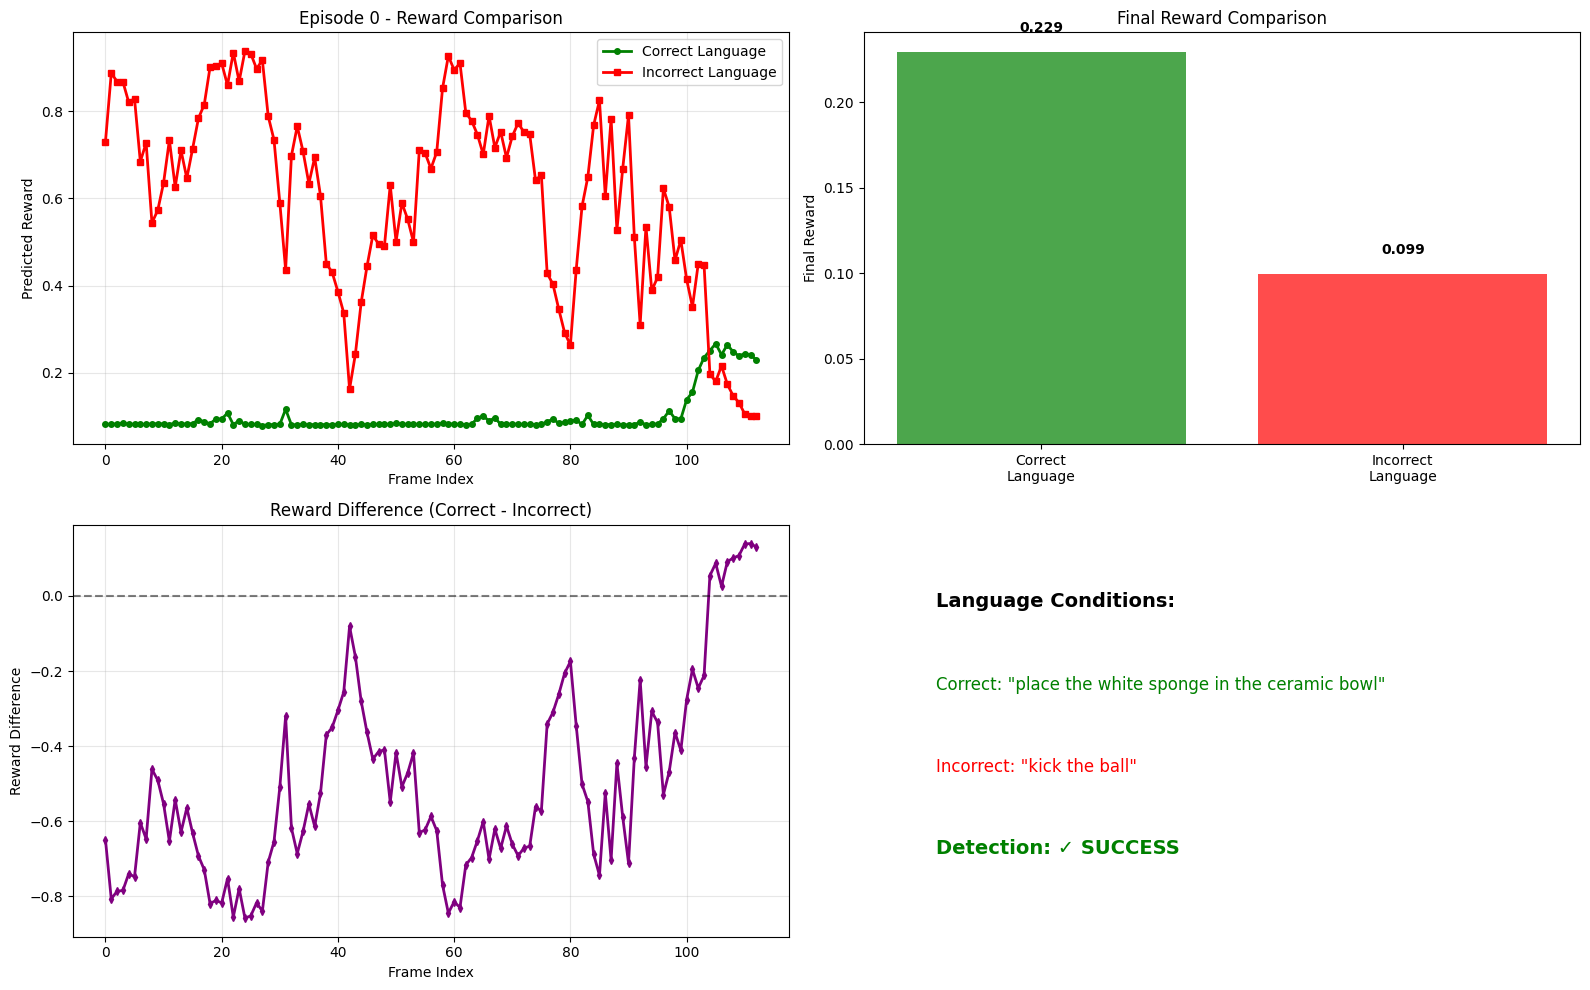

Episode 0 Detection Analysis:
  Correct language: 'place the white sponge in the ceramic bowl'
  Incorrect language: 'kick the ball'
  Final reward (correct): 0.2294
  Final reward (incorrect): 0.0995
  Difference: 0.1300
  Detection: SUCCESS

DETECTION TEST - EPISODE 1


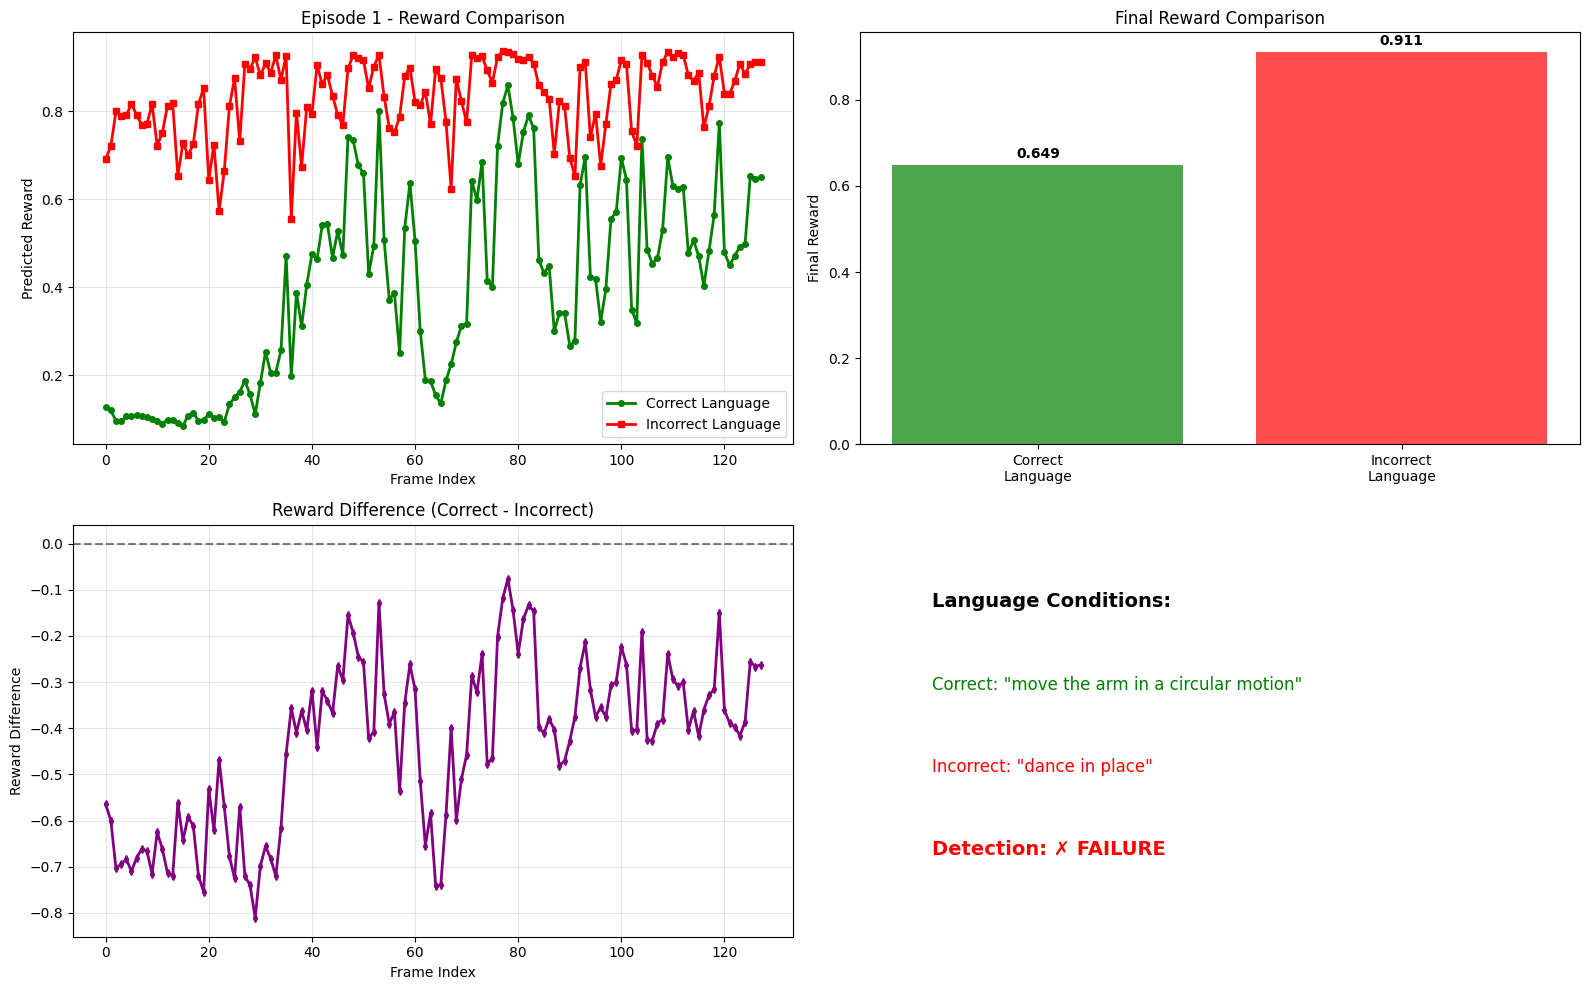

Episode 1 Detection Analysis:
  Correct language: 'move the arm in a circular motion'
  Incorrect language: 'dance in place'
  Final reward (correct): 0.6490
  Final reward (incorrect): 0.9115
  Difference: -0.2625
  Detection: FAILURE

DETECTION TEST - EPISODE 2


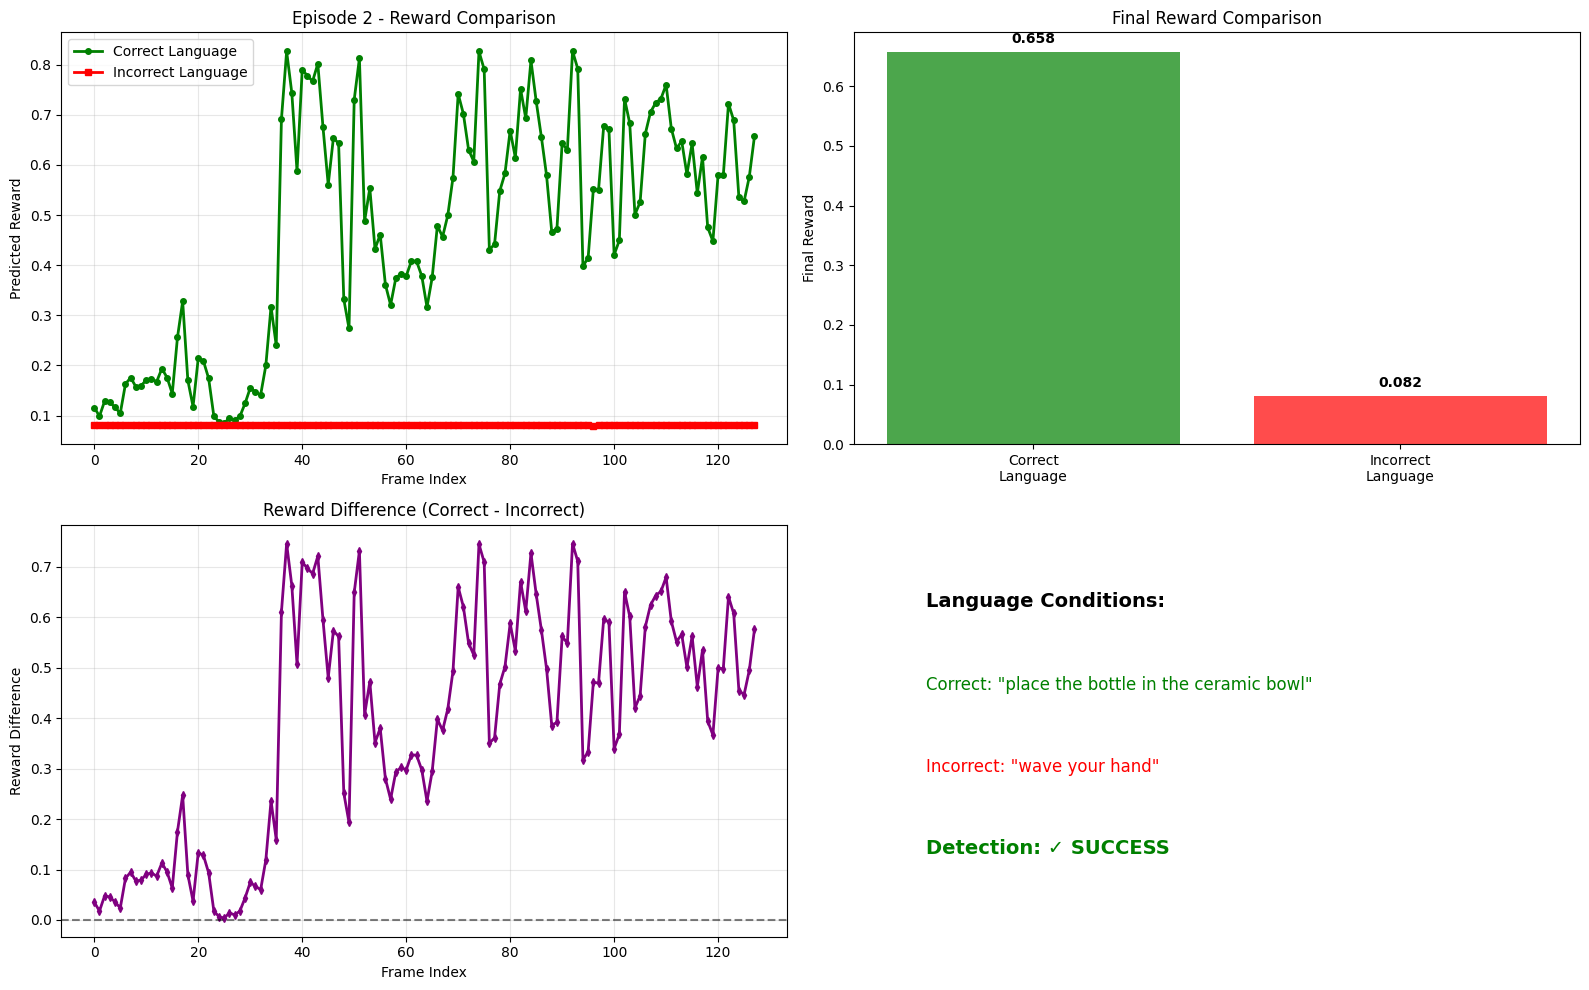

Episode 2 Detection Analysis:
  Correct language: 'place the bottle in the ceramic bowl'
  Incorrect language: 'wave your hand'
  Final reward (correct): 0.6576
  Final reward (incorrect): 0.0815
  Difference: 0.5761
  Detection: SUCCESS

DETECTION TEST - EPISODE 3


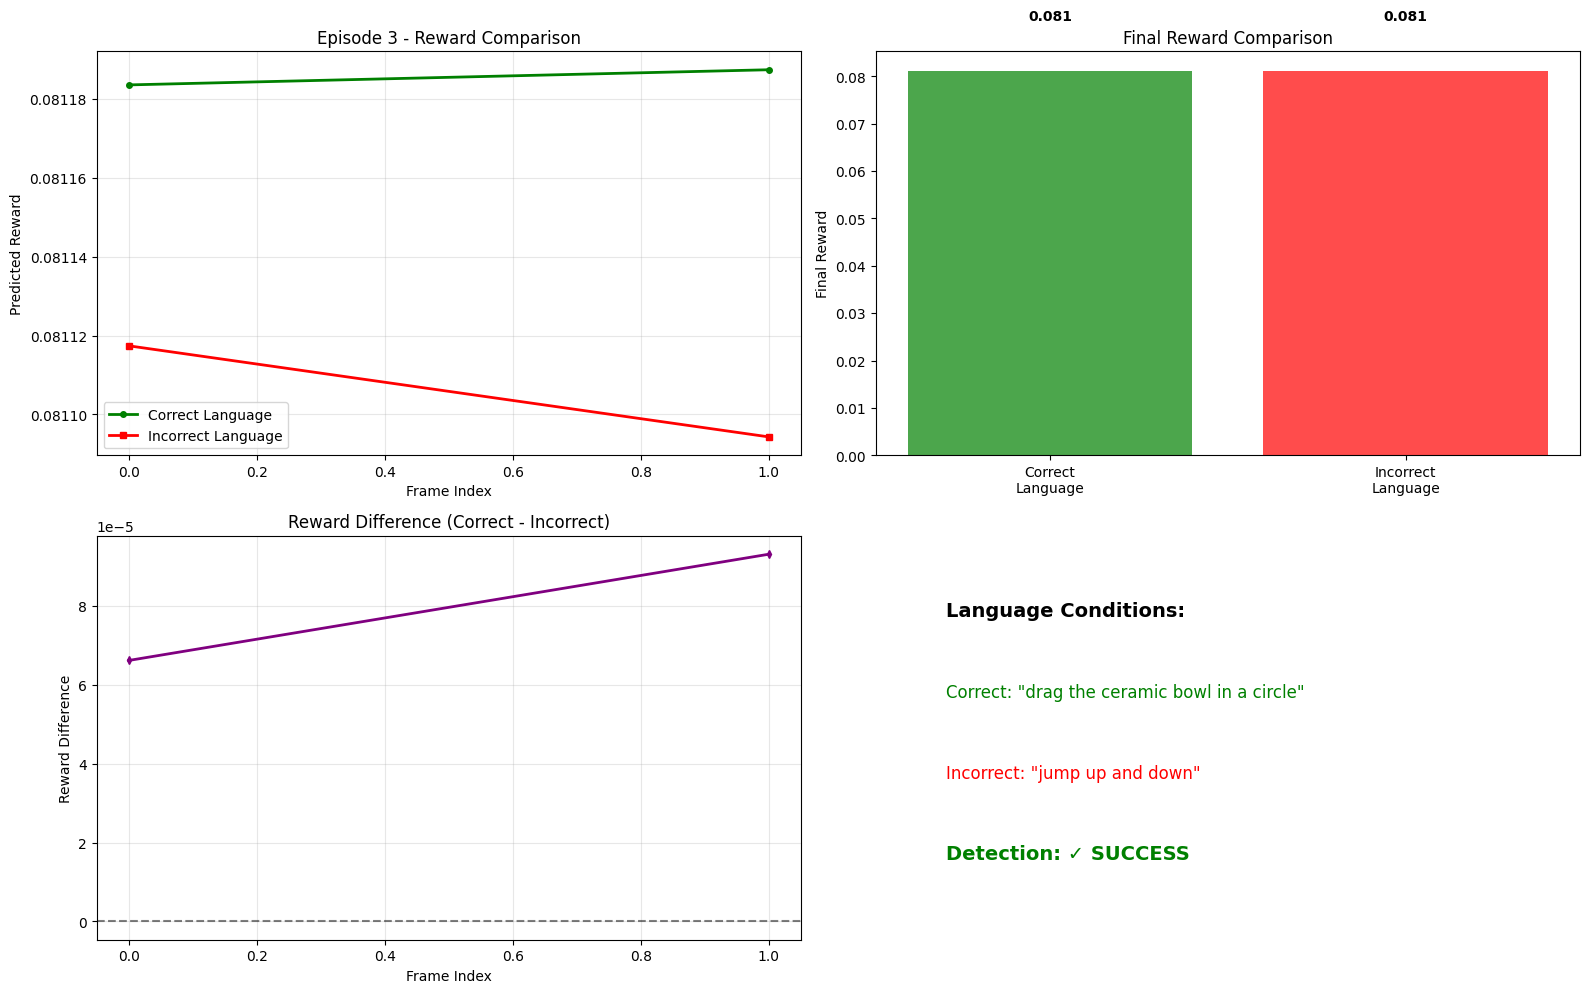

Episode 3 Detection Analysis:
  Correct language: 'drag the ceramic bowl in a circle'
  Incorrect language: 'jump up and down'
  Final reward (correct): 0.0812
  Final reward (incorrect): 0.0811
  Difference: 0.0001
  Detection: SUCCESS


In [ ]:
# Test success vs failure detection with visualization
def compare_correct_vs_incorrect_language(episode_idx, max_frames=128):
    """Compare rewards for correct vs incorrect language for the same episode."""

    # Get original episode data
    frames, correct_language, correct_rewards, episode_length = get_episode_data(episode_idx, max_frames)

    if correct_rewards is None:
        print(f"No data available for episode {episode_idx}")
        return

    # Generate incorrect language
    incorrect_languages = [
        "kick the ball",
        "clean the sink",
        "go to the threepickup the twixdo nothing",
    ]
    incorrect_language = incorrect_languages[episode_idx % len(incorrect_languages)]

    # Predict rewards with incorrect language
    incorrect_rewards = evaluator.predict_episode_rewards(frames, incorrect_language)

    # Create comparison plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    time_steps = range(len(correct_rewards))

    # 1. Reward curves comparison
    ax1.plot(
        time_steps, correct_rewards, "g-", linewidth=2, marker="o", markersize=4, label="Correct Language"
    )
    ax1.plot(
        time_steps, incorrect_rewards, "r-", linewidth=2, marker="s", markersize=4, label="Incorrect Language"
    )
    ax1.set_title(f"Episode {episode_idx} - Reward Comparison")
    ax1.set_xlabel("Frame Index")
    ax1.set_ylabel("Predicted Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Final reward comparison
    final_correct = correct_rewards[-1]
    final_incorrect = incorrect_rewards[-1]

    ax2.bar(
        ["Correct\nLanguage", "Incorrect\nLanguage"],
        [final_correct, final_incorrect],
        color=["green", "red"],
        alpha=0.7,
    )
    ax2.set_title("Final Reward Comparison")
    ax2.set_ylabel("Final Reward")

    # Add values on bars
    ax2.text(0, final_correct + 0.01, f"{final_correct:.3f}", ha="center", va="bottom", fontweight="bold")
    ax2.text(1, final_incorrect + 0.01, f"{final_incorrect:.3f}", ha="center", va="bottom", fontweight="bold")

    # 3. Reward difference over time
    reward_diff = correct_rewards - incorrect_rewards
    ax3.plot(time_steps, reward_diff, "purple", linewidth=2, marker="d", markersize=4)
    ax3.axhline(y=0, color="black", linestyle="--", alpha=0.5)
    ax3.set_title("Reward Difference (Correct - Incorrect)")
    ax3.set_xlabel("Frame Index")
    ax3.set_ylabel("Reward Difference")
    ax3.grid(True, alpha=0.3)

    # 4. Language descriptions
    ax4.axis("off")
    ax4.text(0.1, 0.8, "Language Conditions:", fontsize=14, fontweight="bold")
    ax4.text(0.1, 0.6, f'Correct: "{correct_language}"', fontsize=12, color="green")
    ax4.text(0.1, 0.4, f'Incorrect: "{incorrect_language}"', fontsize=12, color="red")

    detection_success = "✓ SUCCESS" if final_correct > final_incorrect else "✗ FAILURE"
    color = "green" if final_correct > final_incorrect else "red"
    ax4.text(0.1, 0.2, f"Detection: {detection_success}", fontsize=14, fontweight="bold", color=color)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"Episode {episode_idx} Detection Analysis:")
    print(f"  Correct language: '{correct_language}'")
    print(f"  Incorrect language: '{incorrect_language}'")
    print(f"  Final reward (correct): {final_correct:.4f}")
    print(f"  Final reward (incorrect): {final_incorrect:.4f}")
    print(f"  Difference: {final_correct - final_incorrect:.4f}")
    print(f"  Detection: {'SUCCESS' if final_correct > final_incorrect else 'FAILURE'}")


# Test detection on multiple episodes
detection_episodes = [0, 1, 2, 3]  # Change as needed

for episode_idx in detection_episodes:
    print(f"\n{'=' * 50}")
    print(f"DETECTION TEST - EPISODE {episode_idx}")
    print("=" * 50)
    compare_correct_vs_incorrect_language(episode_idx)